In [49]:
# 1. Imports + Load datasets
import pandas as pd
import matplotlib.pyplot as plt
# ======== FOLDER SETUP (add this at the top) ========
import os
from pathlib import Path

# Base directory of the project (you are inside notebooks/)
BASE_DIR = Path("..").resolve()

# Paths for processed data and figures
PROCESSED_DIR = BASE_DIR / "data" / "processed"
FIGURES_DIR = BASE_DIR / "reports" / "figures"

# Create folders if they do not exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Processed directory:", PROCESSED_DIR)
print("Figures directory:", FIGURES_DIR)
# ======================================================



path_eng = "../data/raw/premierleague_dataset.xlsx"
path_pol = "../data/raw/ekstraklasa_dataset.xlsx"

df_eng = pd.read_excel(path_eng)
df_pol = pd.read_excel(path_pol)


df_eng['League'] = 'England'
df_pol['League'] = 'Poland'

df = pd.concat([df_eng, df_pol], ignore_index=True)

df.head()


Processed directory: C:\Users\barto\Documents\2025_Football_Home_Advantage\data\processed
Figures directory: C:\Users\barto\Documents\2025_Football_Home_Advantage\reports\figures


,Date,Home,Away,HG,AG,Res,League
0,2024-08-16,Man United,Fulham,1,0,H,England
1,2024-08-17,Ipswich,Liverpool,0,2,A,England
2,2024-08-17,Arsenal,Wolves,2,0,H,England
3,2024-08-17,Everton,Brighton,0,3,A,England
4,2024-08-17,Newcastle,Southampton,1,0,H,England


In [50]:
# 2. Prepare variables

# Res column:
# H = home win, A = away win, D = draw

df['HomeWin'] = (df['Res'] == 'H').astype(int)
df['AwayWin'] = (df['Res'] == 'A').astype(int)
df['Draw']    = (df['Res'] == 'D').astype(int)

df[['League', 'Home', 'Away', 'HG', 'AG', 'Res', 'HomeWin', 'AwayWin', 'Draw']].head()


,League,Home,Away,HG,AG,Res,HomeWin,AwayWin,Draw
0,England,Man United,Fulham,1,0,H,1,0,0
1,England,Ipswich,Liverpool,0,2,A,0,1,0
2,England,Arsenal,Wolves,2,0,H,1,0,0
3,England,Everton,Brighton,0,3,A,0,1,0
4,England,Newcastle,Southampton,1,0,H,1,0,0


In [51]:
# 3a. Overall distribution

overall_counts = df['Res'].value_counts().rename(index={'H':'Home win', 'A':'Away win', 'D':'Draw'})
overall_perc = (overall_counts / overall_counts.sum() * 100).round(2)

print("Overall result distribution:")
print(pd.DataFrame({'Matches': overall_counts, 'Percent (%)': overall_perc}))


Overall result distribution:
          Matches  Percent (%)
Res                           
Home win      292        42.57
Away win      224        32.65
Draw          170        24.78


In [52]:
# 3b. Distribution per league

league_res = (
    df.groupby('League')['Res']
      .value_counts()
      .unstack(fill_value=0)
      .rename(columns={'H':'Home win', 'A':'Away win', 'D':'Draw'})
)

league_res_percent = (league_res.div(league_res.sum(axis=1), axis=0) * 100).round(2)

print("Results by league (counts):")
display(league_res)

print("Results by league (percent):")
display(league_res_percent)


Results by league (counts):


Res,Away win,Draw,Home win
League,,,
England,132,93,155
Poland,92,77,137


Results by league (percent):


Res,Away win,Draw,Home win
League,,,
England,34.74,24.47,40.79
Poland,30.07,25.16,44.77


In [53]:
# 4. Home advantage summary function

def home_advantage_summary(data):
    total_matches = len(data)
    home_wins = (data['Res'] == 'H').sum()
    away_wins = (data['Res'] == 'A').sum()
    draws = (data['Res'] == 'D').sum()
    
    return pd.Series({
        'Matches': total_matches,
        'Home wins': home_wins,
        'Away wins': away_wins,
        'Draws': draws,
        'Home win rate (%)': round(home_wins / total_matches * 100, 2),
        'Away win rate (%)': round(away_wins / total_matches * 100, 2),
    })

summary_all = home_advantage_summary(df)
summary_by_league = df.groupby('League').apply(home_advantage_summary)

print("Summary – All matches combined:")
display(summary_all.to_frame().T)

print("Summary – By league:")
display(summary_by_league)


Summary – All matches combined:


C:\Users\barto\AppData\Local\Temp\ipykernel_24172\2082427809.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_by_league = df.groupby('League').apply(home_advantage_summary)


,Matches,Home wins,Away wins,Draws,Home win rate (%),Away win rate (%)
0,686.0,292.0,224.0,170.0,42.57,32.65


Summary – By league:


,Matches,Home wins,Away wins,Draws,Home win rate (%),Away win rate (%)
League,,,,,,
England,380.0,155.0,132.0,93.0,40.79,34.74
Poland,306.0,137.0,92.0,77.0,44.77,30.07


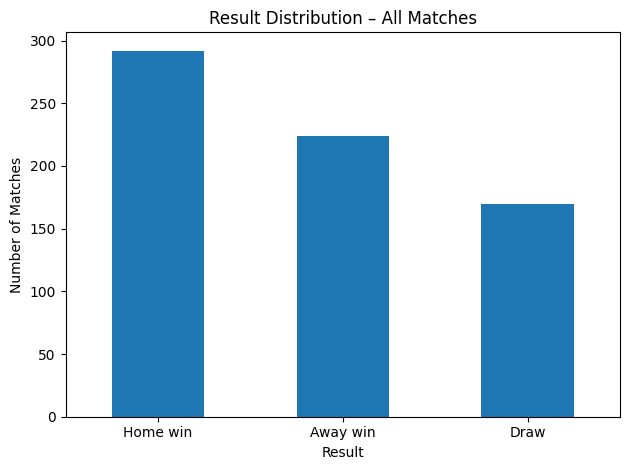

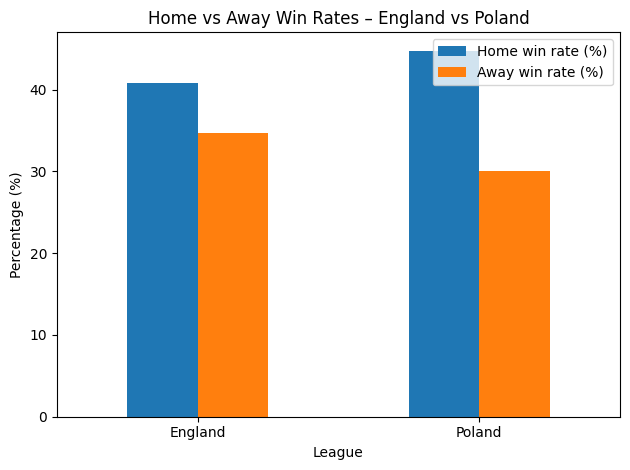

In [54]:
# 5a. Overall distribution plot: show + save
fig1, ax1 = plt.subplots()

overall_counts.plot(kind='bar', ax=ax1)
ax1.set_title("Result Distribution – All Matches")
ax1.set_ylabel("Number of Matches")
ax1.set_xlabel("Result")
ax1.tick_params(axis='x', rotation=0)

fig1.tight_layout()
fig1.savefig(FIGURES_DIR / "overall_result_distribution.png", bbox_inches="tight")
plt.show()
plt.close(fig1)


# 5b. Comparison plot of England vs Poland: show + save
plot_df = summary_by_league[['Home win rate (%)', 'Away win rate (%)']]

fig2, ax2 = plt.subplots()

plot_df.plot(kind='bar', ax=ax2)
ax2.set_title("Home vs Away Win Rates – England vs Poland")
ax2.set_ylabel("Percentage (%)")
ax2.set_xlabel("League")
ax2.tick_params(axis='x', rotation=0)

fig2.tight_layout()
fig2.savefig(FIGURES_DIR / "home_vs_away_results.png", bbox_inches="tight")
plt.show()
plt.close(fig2)


In [55]:
# # 5b. Comparison plot of England vs Poland

# plot_df = summary_by_league[['Home win rate (%)', 'Away win rate (%)']]

# plot_df.plot(kind='bar')
# plt.title("Home vs Away Win Rates – England vs Poland")
# plt.ylabel("Percentage (%)")
# plt.xlabel("League")
# plt.xticks(rotation=0)
# plt.tight_layout()
# plt.show()


In [57]:
# ======================================================
# SAVE FIGURES (ONLY TWO DISTINCT PLOTS)
# ======================================================

# 1) Overall result distribution – all matches (counts)
fig1, ax1 = plt.subplots()

overall_counts.plot(kind='bar', ax=ax1)
ax1.set_title("Result Distribution – All Matches")
ax1.set_ylabel("Number of Matches")
ax1.set_xlabel("Result")
ax1.tick_params(axis='x', rotation=0)

fig1.tight_layout()
fig1.savefig(FIGURES_DIR / "overall_result_distribution.png", bbox_inches="tight")
plt.close(fig1)


# 2) Home vs away win rates – England vs Poland (percentages)
fig2, ax2 = plt.subplots()

plot_df = summary_by_league[['Home win rate (%)', 'Away win rate (%)']]
plot_df.plot(kind='bar', ax=ax2)

ax2.set_title("Home vs Away Win Rates – England vs Poland")
ax2.set_ylabel("Percentage (%)")
ax2.set_xlabel("League")
ax2.tick_params(axis='x', rotation=0)

fig2.tight_layout()
fig2.savefig(FIGURES_DIR / "home_vs_away_win_rates.png", bbox_inches="tight")
plt.close(fig2)

print("Saved final 2 figures to:", FIGURES_DIR)
# ======================================================


Saved final 2 figures to: C:\Users\barto\Documents\2025_Football_Home_Advantage\reports\figures
